In [1]:
import os
import numpy as np
import torch

from src.resnet import ResNet18
from src.pca import PCATransformer
from src.draw_figures import *
from src.dataloader import CIFARCustom

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
os.makedirs("./data", exist_ok=True) 
os.makedirs("./models", exist_ok=True) 
os.makedirs("./figures", exist_ok=True) 

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

target = 3

train_dataset = CIFARCustom(
    root="./data",
    exclude_class=[target],
    train=True, 
    transform=transform
)

train_size = int(0.8 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train, val, test = random_split(train_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=2)


target_dataset = CIFARCustom(
    root="./data",
    exclude_class=[i for i in range(10) if i != target],
    train=True, 
    transform=transform
)

target_loader = DataLoader(target_dataset, batch_size=64, shuffle=True, num_workers=2)

In [ ]:

len(train_dataset), len(target_dataset), len(train), len(val), len(test)

(45000, 5000, 36000, 6750, 2250)

In [4]:
resnet = ResNet18(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        learning_rate=0.001,
        num_epochs=5,
        weights="./models/resnet18_cifar10_without3.pth"
    )

# history = resnet.train()

Loaded weights from ./models/resnet18_cifar10_without3.pth


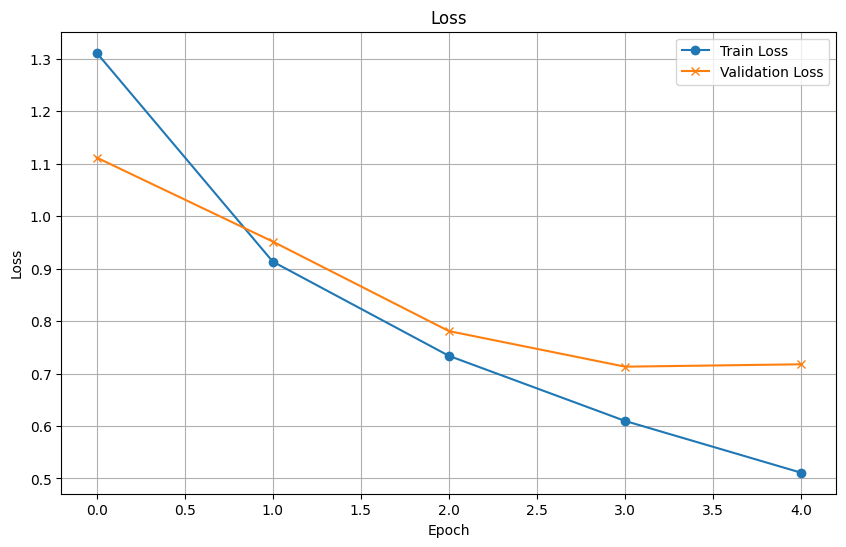

In [ ]:
# plot_loss(history['train_loss'], history['val_loss'])

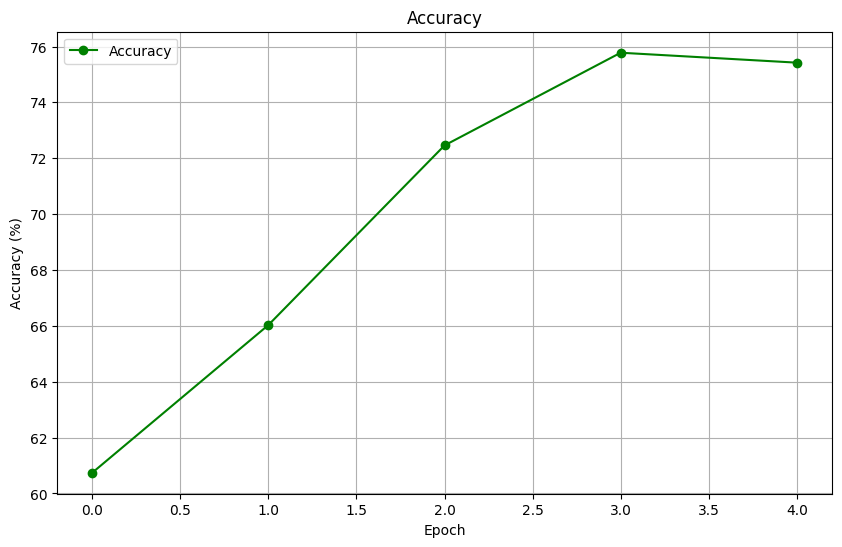

In [ ]:
# plot_accuracy(history['val_accuracy'])

In [5]:
# resnet.save_model('./models/resnet18_cifar10_without3.pth')

In [9]:
features, labels, correct_preds = resnet.extract_features(test_loader)

CR = features[correct_preds == 1]  
WR = features[correct_preds == 0] 


len(CR), len(WR)

(1883, 367)

In [12]:
from sklearn.decomposition import PCA

def apply_pca(train_CR,train_WR, numPC=20, whitening=False, debug=True):
    """
    Применение PCA и проекция данных
    
    Args:
        train_CR, test_CR, train_WR, test_WR (np.ndarray): Матрицы данных
        numPC (int): Число компонент
        whitening (bool): Делать whitening или нет
        debug (bool): Выводить информацию
    
    Returns:
        train_CR_p, test_CR_p, train_WR_p, test_WR_p, pca
    """
    # Учим PCA только на CR_train (как в MATLAB)
    pca = PCA(n_components=numPC, whiten=whitening, random_state=42)
    all_data = np.vstack([train_CR, train_WR])
    pca.fit(all_data)

    # Применяем трансформацию
    train_CR_p = pca.transform(train_CR)
    # test_CR_p  = pca.transform(test_CR)
    train_WR_p = pca.transform(train_WR)
    # test_WR_p  = pca.transform(test_WR)

    if debug:
        print(f"PCA: сохранено {numPC} компонент")
        print(f"Объяснённая дисперсия: {np.sum(pca.explained_variance_ratio_):.2%}")

    return train_CR_p,  train_WR_p, pca


import matplotlib.pyplot as plt

def plot_pca_scatter(train_CR_p, train_WR_p, title="PCA projection (first   2 components)"):
    """
    Визуализация CR и WR в пространстве первых двух компонент PCA
    """
    plt.figure(figsize=(7, 7))
    plt.scatter(train_CR_p[:, 0], train_CR_p[:, 1], 
                alpha=0.5, label="CR (correct)", s=10)
    plt.scatter(train_WR_p[:, 0], train_WR_p[:, 1], 
                alpha=0.5, label="WR (wrong)", s=10, marker="x", c="red")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

PCA: сохранено 50 компонент
Объяснённая дисперсия: 97.91%


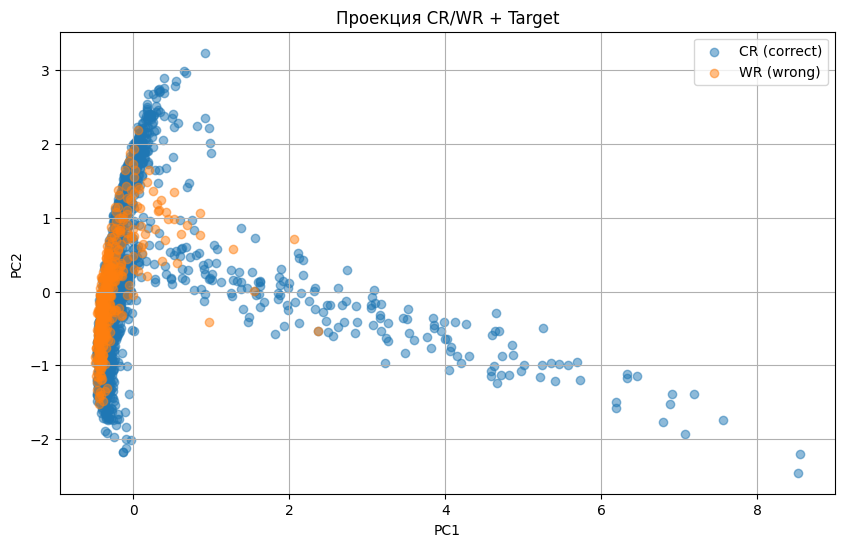

In [13]:
CR_p, WR_p, pca = apply_pca(
    CR, 
    WR,
    numPC=50,         
    whitening=True     
)

plot_pca_projection(CR_p, WR_p)

In [41]:
features, labels, correct_preds = resnet.extract_features(target_loader)

CR = features[correct_preds == 1]  
WR = features[correct_preds == 0] 

len(CR), len(WR)

(0, 5000)

In [42]:
target_p = pca.transform(features)

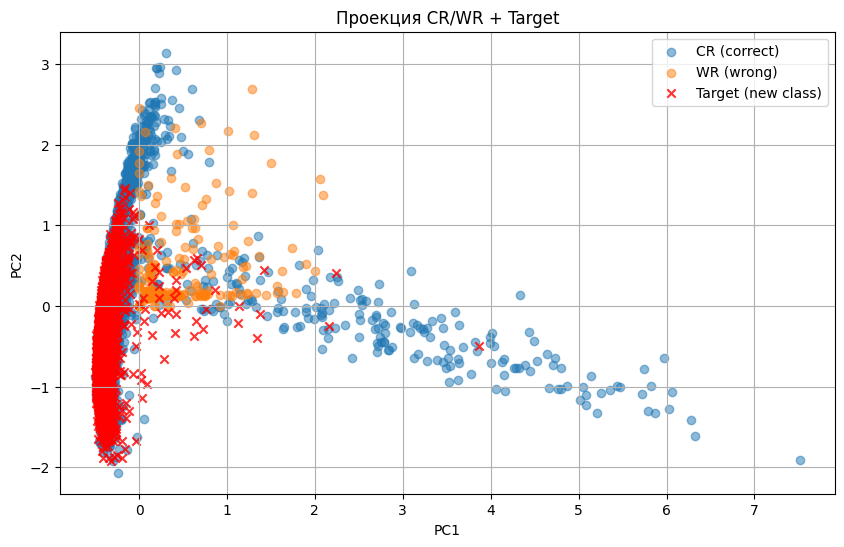

In [43]:
draw_pca_projection(CR_p, WR_p, target_data=target_p)

Финальное количество главных компонент: 21
Объяснённая дисперсия: 0.9495486617088318


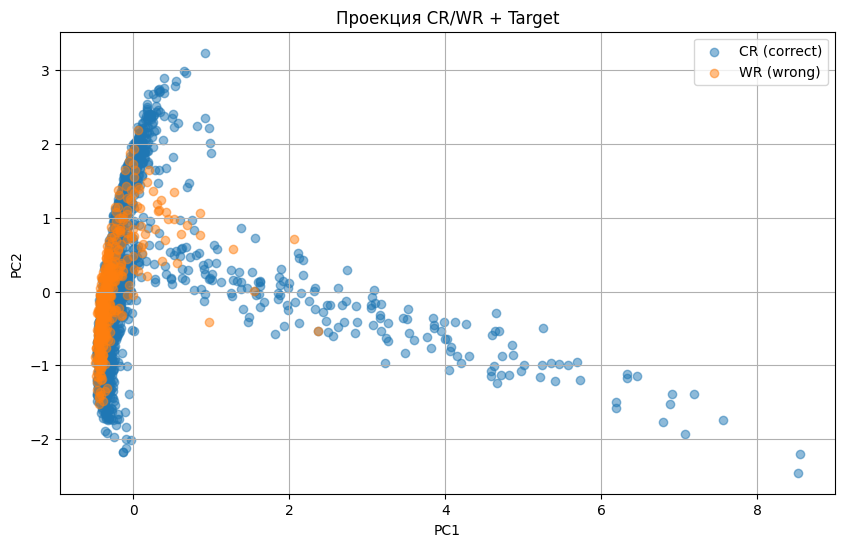

In [14]:
all_train = np.vstack((CR, WR))
pca = PCATransformer(whiten=True) 
pca.fit(all_train)


CR_p = pca.transform(CR)
WR_p = pca.transform(WR)

                            
plot_pca_projection(CR_p, WR_p)

In [16]:
features_t, labels_t, correct_preds_t = resnet.extract_features(target_loader)

CR_t = features_t[correct_preds_t == 1]  
WR_t = features_t[correct_preds_t == 0] 

len(CR_t), len(WR_t)

(0, 5000)

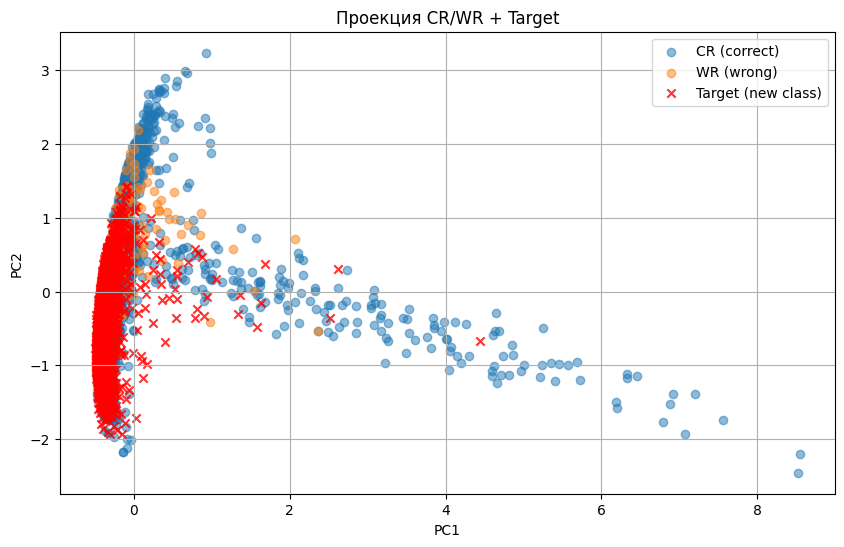

In [17]:
target_p = pca.transform(features_t)
plot_pca_projection(CR_p, WR_p, target_data=target_p)

In [ ]:
draw_pca_projection(CR_p, WR_p, target_data=target_p)

In [ ]:
all_train = np.vstack((train_CR, train_WR))
pca = PCATransformer(n_components='auto', whiten=True) 
pca.fit(train_CR)


train_CR_pca = pca.transform(train_CR)
train_WR_pca = pca.transform(train_WR)
test_CR_pca = pca.transform(test_CR)
test_WR_pca = pca.transform(test_WR)

draw_pca_projection(train_CR_pca, train_WR_pca)

In [24]:
prep = Preprocessing(
    weigths_path="models/weights_resnet18.pth",
    data_path="./data"
) 

train_CR, test_CR, train_WR, test_WR, centre = prep.get_data(center="All")

Правильные предсказания (CR): 7949
Ошибки (WR): 2051
Центр посчитан по: All


PCA: сохранено 50 компонент
Объяснённая дисперсия: 99.37%


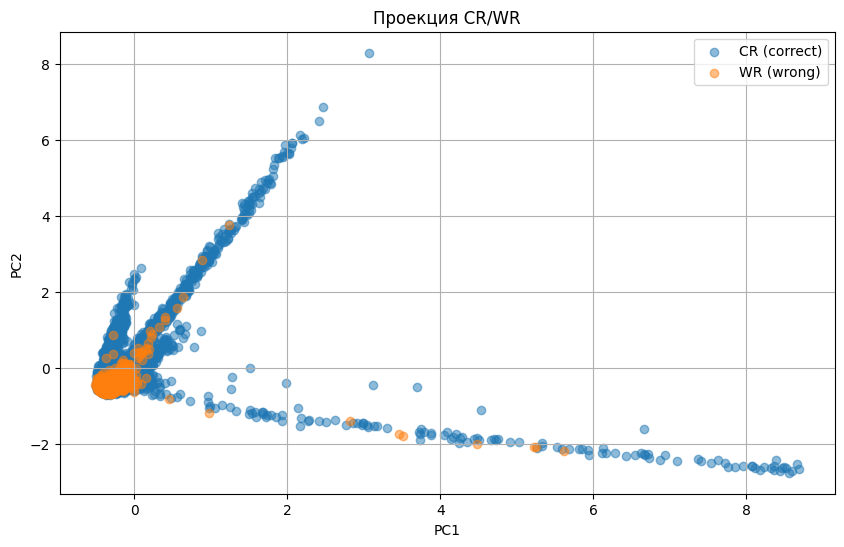

In [ ]:
train_CR_p, test_CR_p, train_WR_p, test_WR_p, pca = apply_pca(
    train_CR, test_CR, train_WR, test_WR,
    numPC=50,         
    whitening=True     
)

draw_pca_projection(train_CR_p, train_WR_p)

In [ ]:
from sklearn.cluster import KMeans

def cluster_wr(train_WR_p, num_clusters=10, debug=True):

    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    wr_labels = kmeans.fit_predict(train_WR_p)

    if debug:
        counts = np.bincount(wr_labels)
        print("Размеры кластеров WR:", counts)

    return wr_labels, kmeans

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def train_fisher_discriminant(train_CR_p, train_WR_p, wr_labels):

    X = np.vstack([train_CR_p, train_WR_p])
    y = np.hstack([np.zeros(len(train_CR_p)), wr_labels + 1])  
    # CR = 0, WR кластеры = 1..k

    lda = LinearDiscriminantAnalysis(solver="svd")  
    lda.fit(X, y)

    return lda

In [ ]:
def evaluate_fisher(lda, test_CR_p, test_WR_p):

    X_test = np.vstack([test_CR_p, test_WR_p])
    y_test = np.hstack([np.zeros(len(test_CR_p)), np.ones(len(test_WR_p))])  # 0=CR, 1=WR

    y_pred = lda.predict(X_test)
    acc = np.mean(y_pred == y_test)

    print(f"Accuracy Fisher discriminant: {acc:.2%}")
    return y_pred, y_test

In [39]:
# 1. Кластеризация WR
wr_labels, kmeans = cluster_wr(train_WR_p, num_clusters=10)

# 2. Дискриминант Фишера
lda = train_fisher_discriminant(train_CR_p, train_WR_p, wr_labels)

# 3. Оценка на тесте
y_pred, y_test = evaluate_fisher(lda, test_CR_p, test_WR_p)

Размеры кластеров WR: [ 94 123 129 148  71  62  76 144 103  75]
Accuracy Fisher discriminant: 59.67%


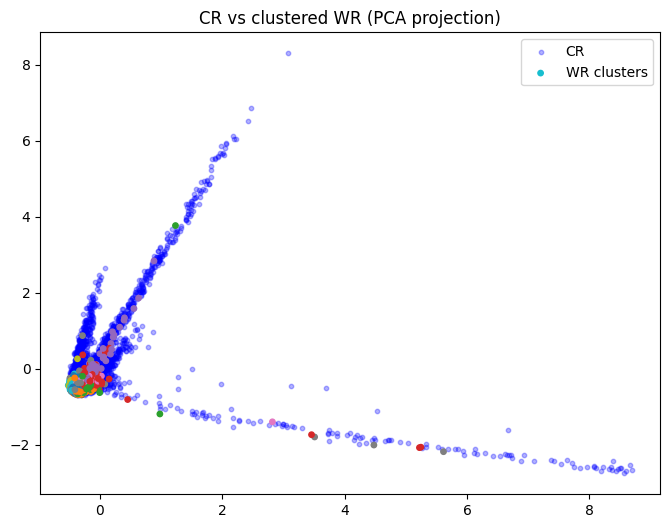

In [31]:
import matplotlib.pyplot as plt

def plot_wr_clusters(train_CR_p, train_WR_p, wr_labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(train_CR_p[:,0], train_CR_p[:,1], s=10, c="blue", alpha=0.3, label="CR")
    plt.scatter(train_WR_p[:,0], train_WR_p[:,1], s=15, c=wr_labels, cmap="tab10", label="WR clusters")
    plt.legend()
    plt.title("CR vs clustered WR (PCA projection)")
    plt.show()

plot_wr_clusters(train_CR_p, train_WR_p, wr_labels)

In [33]:
# all_train = np.vstack((train_CR, train_WR))
# pca = PCATransformer(n_components='auto', whiten=True) 
# pca.fit(all_train)


# train_CR_pca = pca.transform(train_CR)
# train_WR_pca = pca.transform(train_WR)
# test_CR_pca = pca.transform(test_CR)
# test_WR_pca = pca.transform(test_WR)

# draw_pca_projection(train_CR_pca, train_WR_pca)

Финальное количество главных компонент: 14


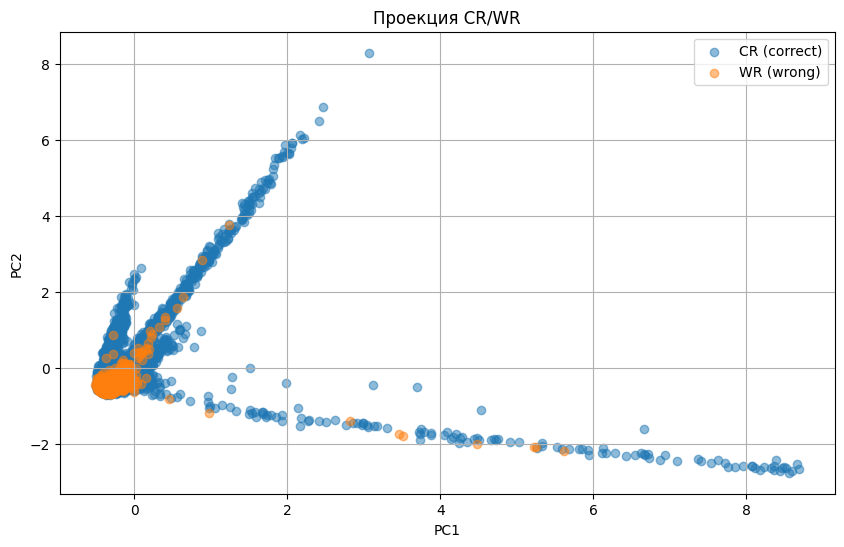

In [34]:
all_train = np.vstack((train_CR, train_WR))
pca = PCATransformer(n_components='auto', whiten=True) 
pca.fit(train_CR)


train_CR_pca = pca.transform(train_CR)
train_WR_pca = pca.transform(train_WR)
test_CR_pca = pca.transform(test_CR)
test_WR_pca = pca.transform(test_WR)

draw_pca_projection(train_CR_pca, train_WR_pca)

In [35]:
# all_train = np.vstack((train_CR, train_WR))
pca = PCATransformer(n_components='auto', whiten=False, assume_centered=True) 
pca.fit(train_CR)

train_CR_pca = pca.transform(train_CR)
train_WR_pca = pca.transform(train_WR)
test_CR_pca = pca.transform(test_CR)
test_WR_pca = pca.transform(test_WR)

draw_pca_projection(train_CR_pca, train_WR_pca)

TypeError: PCATransformer.__init__() got an unexpected keyword argument 'assume_centered'

Финальное количество главных компонент: 26


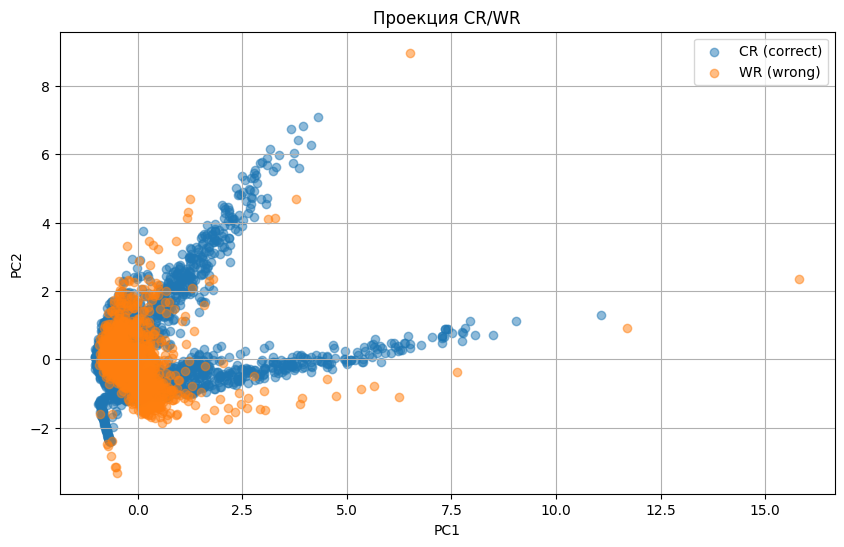

In [ ]:
all_train = np.vstack((train_CR, train_WR))
pca = PCATransformer(n_components='auto', whiten=True) 
pca.fit(train_WR)


train_CR_pca = pca.transform(train_CR)
train_WR_pca = pca.transform(train_WR)
test_CR_pca = pca.transform(test_CR)
test_WR_pca = pca.transform(test_WR)

draw_pca_projection(train_CR_pca, train_WR_pca)

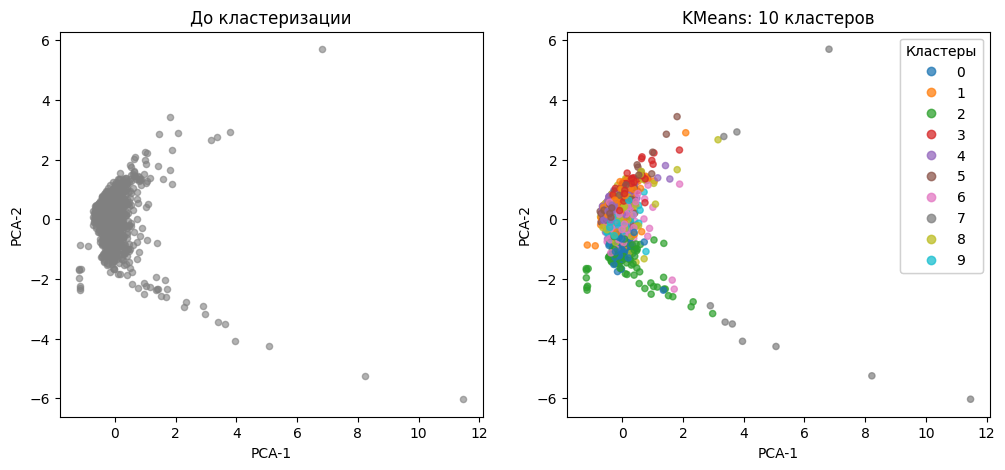

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
n_clusters = 10

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # --- До кластеризации
axs[0].scatter(train_WR_pca[:, 0], train_WR_pca[:, 1], c='gray', alpha=0.6, s=20)
axs[0].set_title("До кластеризации")
axs[0].set_xlabel("PCA-1")
axs[0].set_ylabel("PCA-2")


kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(train_WR_pca)
scatter = axs[1].scatter(train_WR_pca[:, 0], train_WR_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7, s=20)
axs[1].set_title(f"KMeans: {n_clusters} кластеров")
axs[1].set_xlabel("PCA-1")
axs[1].set_ylabel("PCA-2")
legend = axs[1].legend(*scatter.legend_elements(), title="Кластеры", loc="best")
axs[1].add_artist(legend)